# MessageMiner: 
## A script for clustering open-text survey responses

Are you an NLP/LLM wizard? Please help me improve this! Email: [momoko[at]kantan.io](mailto:momoko@kantan.io)




----


## Stage 1: Get embeddings for each document

This stage of the script is a modified version of the ['Obtain_dataset'](https://github.com/openai/openai-cookbook/blob/main/examples/Obtain_dataset.ipynb) notebook from OpenAI's [OpenAI Cookbook](https://github.com/openai/openai-cookbook) on github. 

To complete Stage 1, you will need to have the following packages installed: pandas, openai, transformers, plotly, matplotlib, scikit-learn, torch (transformer dep), torchvision, and scipy.

Also: Ensure you have your API key set in your environment, or added in the following cell, per the README: https://github.com/openai/openai-python#usage

In [1]:
# imports & API authentication
import sys
import numpy as np
import pandas as pd
import tiktoken
import matplotlib
import openai

openai.api_key = "YOUR-API-KEY-GOES-HERE"

In [2]:
##  Using a customized version of 'get_embedding' function so @retry can be adjusted to avoid rate limit errors 
from tenacity import retry, wait_random_exponential, stop_after_attempt

@retry(wait=wait_random_exponential(min=5, max=15), stop=stop_after_attempt(6))
def get_embedding(text: str, model="text-embedding-ada-002") -> list[float]:
    return openai.Embedding.create(input=[text], model=model)["data"][0]["embedding"]

# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [3]:
# load dataset
# for simplicity's sake, the dataset should be a 1-column CSV of short VOC docs, such as survey responses. 

input_datapath = "data/curvy_survey_pain_points.csv"  
df = pd.read_csv(input_datapath)
df.index.name = "id" # set index as id
df = df.dropna()

# inspect it visually
df.head(5)

,text
id,
0,Good fitting
1,Convenient
2,"Uncomfortable wire, finding the time to go int..."
3,Being able to source a large range of styles a...
4,none


In [ ]:
# Generate embeddings for each document and export file to csv (this may take a few minutes). 
# You only need to do this once! 

df["embedding"] = df.text.apply(lambda x: get_embedding(x, model=embedding_model))
df.to_csv("data/curvy_survey_pain_points_with_embeddings.csv")

## Stage 2: Cluster the documents
This stage of the script is a modified version of the ['Clustering'](https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb) notebook from OpenAI's [OpenAI Cookbook](https://github.com/openai/openai-cookbook) on github. 

This modified version allows you to search for the 'optimal' number of clusters for your k-means model over a range of k using the 'elbow' method, rather than randomly picking a single number and fitting the model once.

After identifying a 'target' K via the elbow method, it will then generate avg. silhouette scores for a smaller subset of k around the target K. Whatever value of k generates the highest silhouette score within this range will be assumed to be the best k for clustering our documents. ** 

** _Note: This method of identifying k is far from perfect, it is really just a hack to avoid pure guessing. Suggestions for other more rigorous methods for finding the best k — as well as corrections to the hack I've created so far — are very much welcome and appreciated!_

In [2]:
# additional imports
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# load data (with embeddings)
datafile_path = "./data/curvy_survey_pain_points_with_embeddings.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)

### 2.1 Find optimal # of clusters using K-means, elbow method & silhouette scores

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

Cookbook for optimizing n_clusters:
https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters

In [3]:
def find_best_k_elbow(kmeans_kwargs, k_max, k_min=1):
    sse = []
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(matrix)
        sse.append(kmeans.inertia_)
        
    # plot the elbow graph
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, k_max), sse)
    plt.xticks(range(1, k_max))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
    kl = KneeLocator(
    range(k_min, k_max), 
    sse, 
    curve="convex", 
    direction="decreasing")

    print("\n")
    print(f"Optimal 'elbow' K is: {kl.elbow} clusters.")
    
    return kl.elbow
    
def get_best_silhouette_k(kmeans_kwargs, target_k):
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = {}

    for k in target_k:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(matrix)
        score = silhouette_score(matrix, kmeans.labels_)
        silhouette_coefficients[k] = score
    
    for i in silhouette_coefficients:
        print(f"Silhouette score for K = {i}: {silhouette_coefficients[i]}")
        
    best_k = max(silhouette_coefficients, key=silhouette_coefficients.get)
    best_model = KMeans(n_clusters=best_k, **kmeans_kwargs)
    best_model.fit(matrix)
    
    print("\n")
    print(f"Highest-scoring K is: {best_k} clusters.\n\n")
    
    return(best_model, best_k)
    

In [11]:
# set default parameters for kmeans modeling (may want to try tuning these later)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300
    #"random_state": 42, 
}

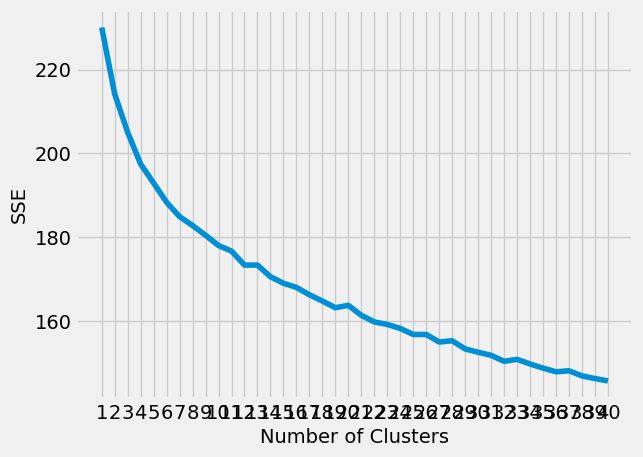



Optimal 'elbow' K is: 12 clusters.


In [12]:
k_max = int(len(df)/25) # k_max = the max number of clusters to try to model. 

elbow_k = find_best_k_elbow(kmeans_kwargs, k_max) # cluster our dataset with # of clusters (k) ranging from 1 to k_max.  

# NOTE: You can set k_max to whatever you want. I defined k_max to be in some way proportional to total sample size. In this case, k_max is total sample size divided by an avg. cluster size of 25 documents per cluster. The more  documents you have, the higher range of clusters the elbow method will test.

In [13]:
# Get silhouette scores for different ranges of k around elbow_k, because the elbow method is still very 'fuzzy' in its conclusiveness. It's a good idea to see if any other k values produce marginally better scores.

k_min = elbow_k - 5
k_max = elbow_k + 5

best_model, best_k = get_best_silhouette_k(kmeans_kwargs, range(k_min, k_max))

Silhouette score for K = 7: 0.07399775913971599
Silhouette score for K = 8: 0.07712532840115838
Silhouette score for K = 9: 0.07844632181346188
Silhouette score for K = 10: 0.062454507391524805
Silhouette score for K = 11: 0.06674665148972404
Silhouette score for K = 12: 0.06209079174639158
Silhouette score for K = 13: 0.05924447351340137
Silhouette score for K = 14: 0.07061259293015483
Silhouette score for K = 15: 0.06093543347323623
Silhouette score for K = 16: 0.06949079434626759


Highest-scoring K is: 9 clusters.




### 2.2 Summarizing themes for each cluster based on random sampling

We'll use text-davinci-003 to describe the common theme within each cluster, based on a random sample of 10 documents from that cluster.

In [14]:
df["cluster"] = best_model.labels_  # categorize each document by assigning it to a cluster

In [15]:
# create master dataset where all documents are clustered in groups, and sorted from largest group to smallest

cluster_list = []

for i in range(best_k):
    sampling_seed = 42
    cluster_size = len(df[df.cluster == i])
    
    if len(df[df.cluster == i]) > 10:
        sample_per_cluster = 10
    else: 
        sample_per_cluster = cluster_size
        
    sample_cluster_rows = df[df.cluster == i].sample(sample_per_cluster, random_state=sampling_seed).text

    samples = "\n".join(
        sample_cluster_rows
        .values
    )

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following survey responses have in common?\n\nSurvey Responses:\n"""\n{samples}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    
    cluster_elements = {"cluster_num": "cluster_"+str(i+1),
                        "cluster_size": cluster_size,
                        "cluster_docs": df[df.cluster == i].text,
                        "sample_verbatims": sample_cluster_rows,
                        "cluster_theme": response["choices"][0]["text"].replace(".\n", "")}
    
    cluster_list.append(cluster_elements)
    
# save all cluster-specific data, including summaries generated by text-davinci-003, to a master df
cluster_df = (pd.DataFrame(cluster_list)
              .sort_values(by='cluster_size', ascending=False)
              .reset_index()
              .drop(['index', 'cluster_num'], axis=1))

cluster_df.index = np.arange(1, len(cluster_df) + 1)
cluster_df.index.name = "cluster_id"

# subset the columns we're interested in
full_results_df = cluster_df[["cluster_theme", "cluster_size", "sample_verbatims", "cluster_docs"]]

## Stage 3: Save the results to output files

We'll export our clustering results to 2 output files: 

**FILE 1:** A text summary file that lists the clusters in order of descending size, describes the common theme for each, and lists a sample of verbatims to get the 'jist' of the overarching message in the customers' own words. 

**FILE 2:** A multi-tab spreadsheet that includes an overview tab that lists the clusters found, and then subsequent tabs that contain all the documents that were assigned to each cluster. These tabs are intended to be useful for copywriters and marketers who may want to use these clusters to further train GPT-3, or simply look for "swipe-worthy" statements and turns of phrases to inject into content assets (ads, LPs, emails, etc.)

**NOTE:** In the larger clusters, it's likely that there will be some noticeable 'noise' wherein some documents won't seem like they belong ('one of these things is not like the other ...'). But the major overarching theme should prevail/dominate as the most common message within that cluster. If not, the model needs to be tuned further.

In [16]:
# hideous hacky function for getting the results into usable, readable files
def export_files(df):
    
    import os
    if not os.path.exists('data/messageminer_results'):
        os.makedirs('data/messageminer_results') 
    
    original_stdout = sys.stdout # Save a reference to the original standard output
    
    with open('data/messageminer_results/cluster_summary.txt', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        for idx, row in full_results_df.iterrows():
    
            print(f"Cluster Id: ", idx)
            print(f"Cluster Theme:", end=" ")
            print(row["cluster_theme"])
            print(f"Cluster Size: ", row['cluster_size'])
            print("\n")

            print("VERBATIMS FROM CUSTOMERS:")
            print("\n")
            
            for i in row['sample_verbatims']:
                print('"'+i+'"')

            print('\n')
            print("-" * 100)
            print('\n')

        sys.stdout = original_stdout # Reset the standard output to its original value

    f.close()
    
    
    with pd.ExcelWriter('data/messageminer_results/voc_clustered.xlsx') as writer:
        
        # save to summary info as cover sheet
        print(f"Saving summary sheet first ...")
        overview_df = df[["cluster_theme", "cluster_size"]]
        overview_df.T.reset_index().T.to_excel(writer,sheet_name="clusters_overview",header=None, index=None) 
        
        # save each group of documents to separate tabs
        for idx, row in df.iterrows():
            # create output df
            row['cluster_docs'].name = "THEME: " + row['cluster_theme'].upper()
            sheet_df = row['cluster_docs'].to_frame()
            sheet_label = "cluster_" + str(idx)
            
            # save to file as worksheet
            print(f"Saving docs to worksheet #{idx} ...")
            sheet_df.T.reset_index().T.to_excel(writer,sheet_name=sheet_label,header=None, index=None)    
    
    print("Done!")

In [17]:
export_files(full_results_df)

Saving summary sheet first ...
Saving docs to worksheet #1 ...
Saving docs to worksheet #2 ...
Saving docs to worksheet #3 ...
Saving docs to worksheet #4 ...
Saving docs to worksheet #5 ...
Saving docs to worksheet #6 ...
Saving docs to worksheet #7 ...
Saving docs to worksheet #8 ...
Saving docs to worksheet #9 ...
Done!
